In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import attention
import transformers
import torch

import helper
from helper import *

In [2]:
df = load_and_preprocess()
df = df.reset_index(drop = True)

In [3]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

#### Just Using Date/Previous Hour Temp.

In [4]:
df.head()

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01 13:00:00,heavy clouds,93.0,1001.0,285.830000,230.0,4.0,1,0,0,0,0,0,0,0,3.0
1,2012-10-01 14:00:00,sky is clear,91.0,986.0,285.834650,230.0,4.0,0,0,0,0,0,0,0,0,0.0
2,2012-10-01 15:00:00,sky is clear,87.0,945.0,285.847790,231.0,4.0,0,0,0,0,0,0,0,0,0.0
3,2012-10-01 16:00:00,sky is clear,84.0,904.0,285.860929,233.0,4.0,0,0,0,0,0,0,0,0,0.0
4,2012-10-01 17:00:00,sky is clear,80.0,863.0,285.874069,234.0,3.0,0,0,0,0,0,0,0,0,0.0


In [5]:
train = df[:cutoff].reset_index(drop = True)
train = train.iloc[:, 4:5].values
test = df[cutoff:]
test = test.iloc[:, 4:5].values

In [6]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [7]:
def split(sequence, n_timestamp):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], sequence[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [8]:
X_train, y_train = split(sequence = train_std, n_timestamp = 10)
X_test, y_test = split(sequence = test_std, n_timestamp = 10)

In [9]:
print(X_train.shape)
print(X_test.shape)

(33929, 10, 1)
(11303, 10, 1)


In [10]:
print(y_train.shape)
print(y_test.shape)

(33929, 1)
(11303, 1)


In [11]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [12]:
model.compile(loss = 'mse', optimizer = 'adam')

In [13]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
849/849 [==============================] - 8s 7ms/step - loss: 0.0707 - val_loss: 0.0338
Epoch 2/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0158 - val_loss: 0.0083
Epoch 3/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 4/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 5/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 6/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 7/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0108 - val_loss: 0.0074
Epoch 8/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0107 - val_loss: 0.0071
Epoch 9/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 10/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0105 - val_loss: 0.0067

In [14]:
y_pred = model.predict(X_test)

In [15]:
y_test_inv = sc.inverse_transform(y_test)
y_pred_inv = sc.inverse_transform(y_pred)

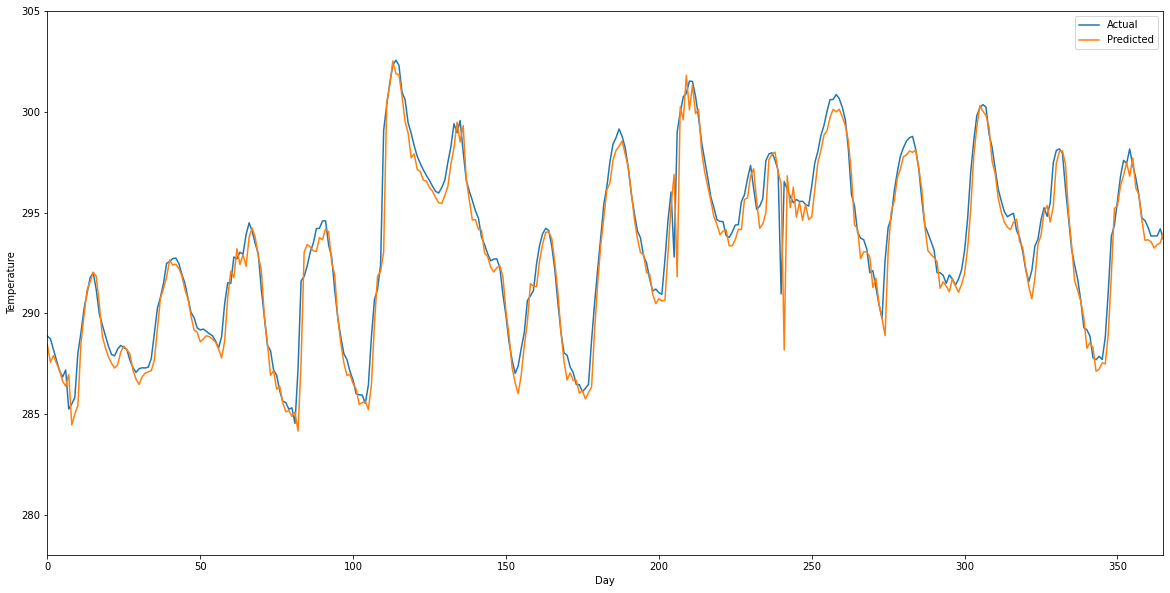

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([278, 305])
plt.legend()
plt.show()

In [234]:
def create_preds(df, n_timestamp=10, y_pred_inv=y_pred_inv, y_test_inv=y_test_inv):
    preds = pd.DataFrame(data=df.loc[cutoff+n_timestamp:, 'datetime'])
    preds['actual'] = df.loc[cutoff+n_timestamp:, 'Temperature']
    preds['pred'] = y_pred_inv
    preds['MAE'] = np.mean(np.abs(y_test_inv - y_pred_inv), axis=1)
    preds['datetime'] = pd.to_datetime(preds['datetime'])

    return preds
    
def create_preds_day(df, n_timestamp=10, y_pred_inv=y_pred_inv, y_test_inv=y_test_inv):
    preds = pd.DataFrame(data=df.loc[cutoff+n_timestamp:, 'datetime'])
    preds['actual'] = df.loc[cutoff+n_timestamp:, 'Temperature']
    preds['pred'] = y_pred_inv
    preds['MAE'] = np.mean(np.abs(y_test_inv - y_pred_inv), axis=1)
    preds['datetime'] = pd.to_datetime(preds['datetime'])

    preds_day = preds.groupby(preds['datetime'].dt.date).agg('mean') #grouping by day
    return preds_day

In [235]:
def plot_daily(preds_day):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['actual']-273.15, name='Actual'))
    fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['pred']-273.15, name='Predicted'))
    fig.update_layout(showlegend=True, title='Test Predictions/Actual Temperatures')
    fig.show()

def plot_error(preds):
    preds_day = create_preds_day(df)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['MAE'], name='Loss'))
    fig.update_layout(showlegend=True, title='Test Error by Day')
    fig.show()
    
def plot(preds_day, preds):
    plot_daily(preds_day)
    plot_error(preds)

In [81]:
plot()

In [82]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

MSE: 0.9993625292889153
R-Squared: 0.991612689812258


In [83]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

0.9996812138321473

#### Trying with multiple predictors

In [84]:
def split_multiple(sequence, n_timestamp, target):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], target[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [85]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.drop(['datetime', 'Description'], axis = 1).values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.drop(['datetime', 'Description'], axis = 1).values

In [86]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [87]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [88]:
X_train.shape

(33929, 10, 14)

In [89]:
y_train.shape

(33929, 1)

In [90]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [91]:
model.compile(loss = 'mse', optimizer = 'adam')

In [92]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
849/849 [==============================] - 7s 6ms/step - loss: 0.1006 - val_loss: 0.0859
Epoch 2/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0299 - val_loss: 0.0317
Epoch 3/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0165 - val_loss: 0.0134
Epoch 4/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0126 - val_loss: 0.0103
Epoch 5/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0116 - val_loss: 0.0095
Epoch 6/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 7/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0112 - val_loss: 0.0092
Epoch 8/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0111 - val_loss: 0.0090
Epoch 9/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0113 - val_loss: 0.0096
Epoch 10/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0110 - val_loss: 0.0101

In [93]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [94]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

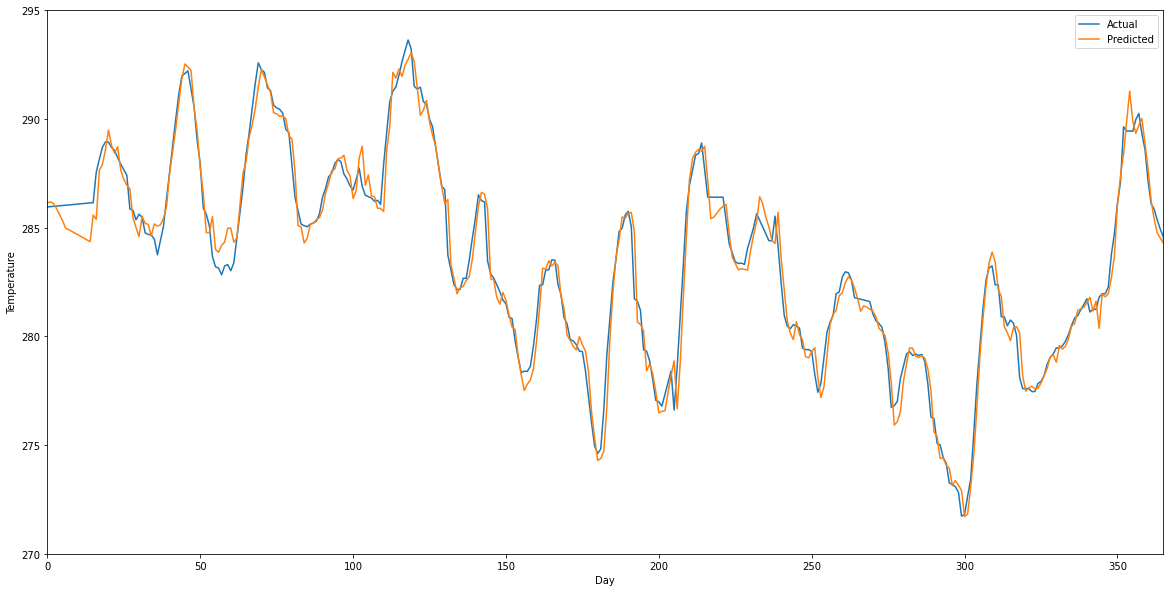

In [95]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [96]:
plot()

In [97]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))

MSE: 2.037322970618753
R-Squared: 0.9864196708982481


In [98]:
math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

1.4273482303273974

### Incorporating Engineered Features

In [115]:
df = feature_engineer_important(load_and_preprocess())

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [116]:
df.iloc[167:170, ] #looks like due to the shifts we should drop the first week of observations (which is fine)

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-16 18:00:00,71.861538,1016.424953,216.0,5.0,18,289.45,289.44,281.24,277.93,280.9,...,271.73,271.73,71.423717,1015.776758,283.270000,199.440476,1015.448112,2.252976,74.794734,289.43
2012-10-16 19:00:00,71.861538,1016.424953,268.0,2.0,19,289.43,289.45,281.80,278.19,280.9,...,271.73,271.73,71.423717,1015.776758,283.289881,199.643917,1015.451011,2.252226,74.786030,289.97
2012-10-16 20:00:00,71.861538,1016.424953,191.0,5.0,20,289.97,289.43,281.96,278.71,280.9,...,271.73,271.73,71.423717,1015.776758,283.310473,199.618343,1015.453892,2.260355,74.777378,290.25


In [119]:
df['datetime'] = pd.to_datetime(df.index)
df = df.dropna()

In [120]:
df.head()

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,284.97,2012-10-09 19:00:00
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,285.58,2012-10-09 20:00:00
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,285.75,2012-10-09 21:00:00
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,285.04,2012-10-09 22:00:00
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,281.73,2012-10-09 23:00:00


#### RNN with New Features

In [123]:
train = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [124]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [125]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [126]:
X_train.shape

(33929, 10, 21)

In [127]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [128]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
849/849 [==============================] - 7s 6ms/step - loss: 0.1133 - val_loss: 0.1019
Epoch 2/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0492 - val_loss: 0.0319
Epoch 3/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0276 - val_loss: 0.0204
Epoch 4/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0200 - val_loss: 0.0192
Epoch 5/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 6/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0158 - val_loss: 0.0134
Epoch 7/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0143 - val_loss: 0.0149
Epoch 8/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0110 - val_loss: 0.0141
Epoch 9/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0099 - val_loss: 0.0134


In [129]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [130]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

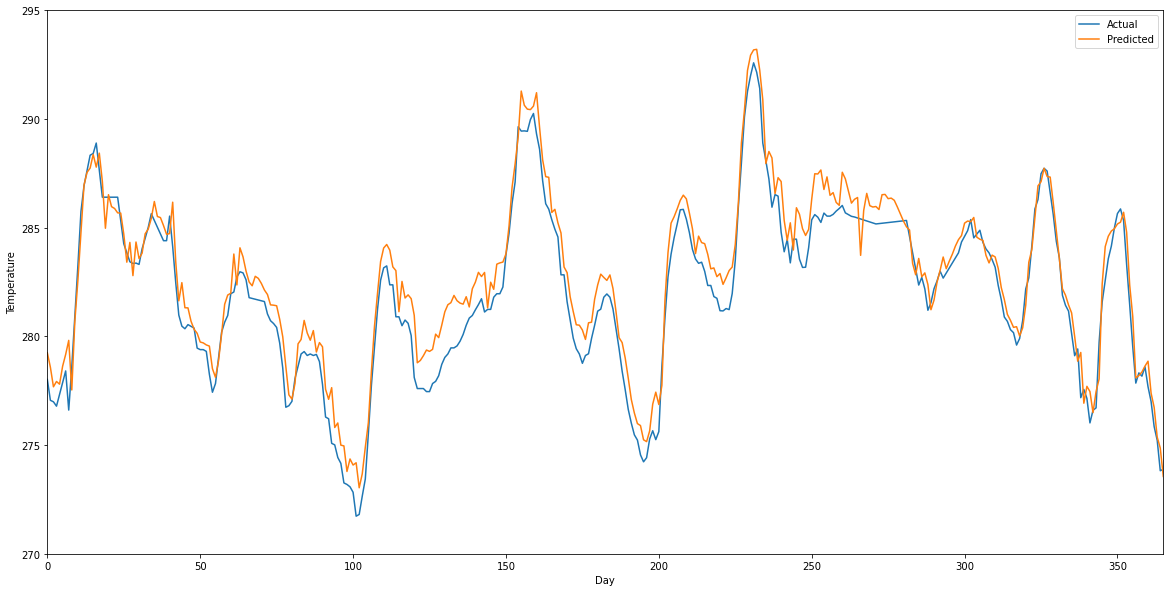

In [131]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [143]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 2.657979254323544
R-Squared: 0.9823539836444982
RMSE: 1.6303310259955013


### Transformers

#### Attention Model

In [144]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [145]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff
df.head()

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,284.97
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,285.58
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,285.75
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,285.04
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,281.73


In [146]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [147]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [148]:
X_train, y_train = split_multiple(train_std, 24, target_train_std)
X_test, y_test = split_multiple(test_std, 24, target_test_std)
X_train.shape

(33766, 24, 21)

In [149]:
model_input = keras.Input(shape = X_train.shape[1:])
x = keras.layers.LSTM(50, return_sequences = True)(model_input)
x = keras.layers.LSTM(50, return_sequences = True)(x)
x = attention.Attention()(x) #incorportating an attention layer in the model
model_output = keras.layers.Dense(1)(x)
model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 21)]     0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 24, 50)       14400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 24, 50)       20200       lstm_8[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 50)           0           lstm_9[0][0]                     
______________________________________________________________________________________________

In [150]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
845/845 [==============================] - 13s 13ms/step - loss: 0.1278 - val_loss: 0.0906
Epoch 2/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0487 - val_loss: 0.0418
Epoch 3/20
845/845 [==============================] - 10s 11ms/step - loss: 0.0318 - val_loss: 0.0314
Epoch 4/20
845/845 [==============================] - 9s 11ms/step - loss: 0.0226 - val_loss: 0.0275
Epoch 5/20
845/845 [==============================] - 9s 11ms/step - loss: 0.0216 - val_loss: 0.0284
Epoch 6/20
845/845 [==============================] - 9s 11ms/step - loss: 0.0204 - val_loss: 0.0103
Epoch 7/20
845/845 [==============================] - 9s 11ms/step - loss: 0.0151 - val_loss: 0.0112
Epoch 8/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0197 - val_loss: 0.0104
Epoch 9/20
845/845 [==============================] - 9s 11ms/step - loss: 0.0212 - val_loss: 0.0101
Epoch 10/20
845/845 [==============================] - 10s 11ms/step - loss: 0.0164 - v

In [151]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

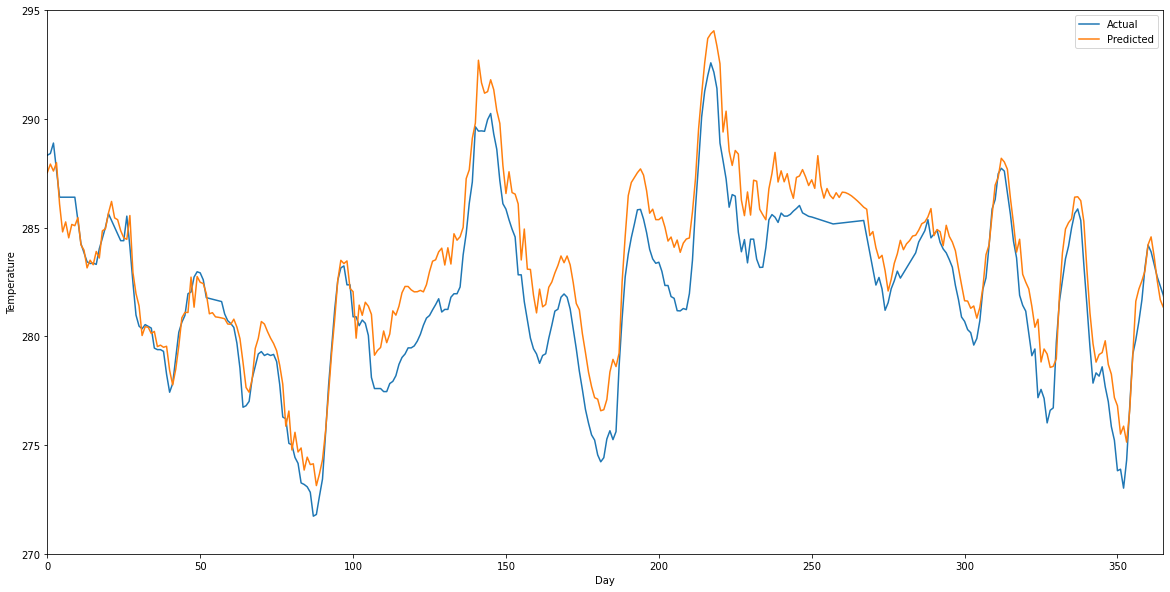

In [152]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

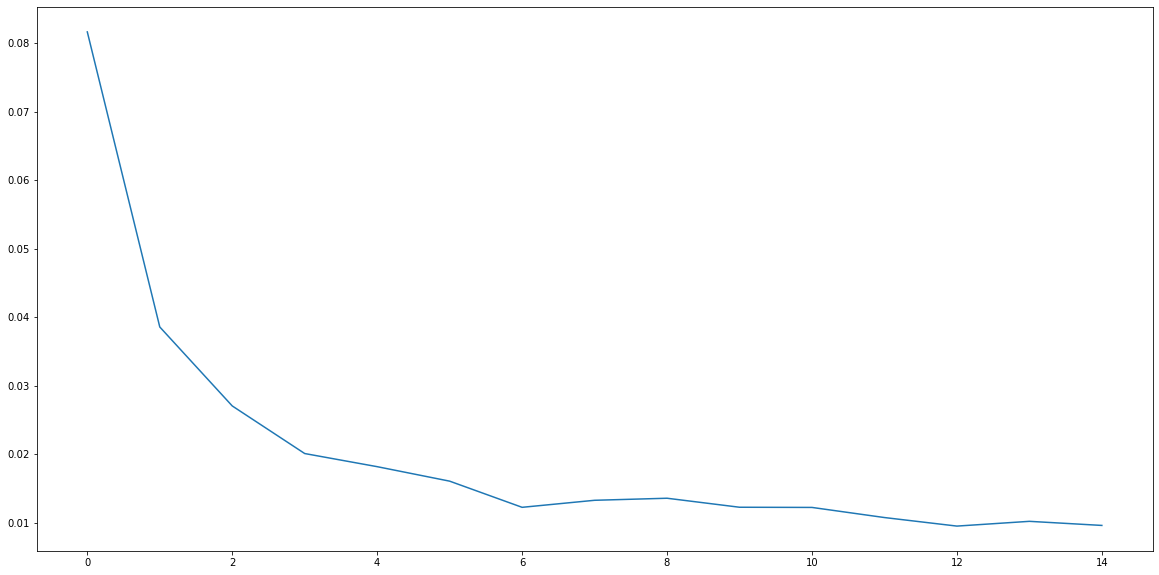

In [153]:
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.show()

In [18]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 1.651484897076956
R-Squared: 0.9890336822704596
RMSE: 1.2851011232883411


----

#### Multi-Head Attention Model

In [158]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()
df.head()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,284.97
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,285.58
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,285.75
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,285.04
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,281.73


In [159]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

In [160]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [161]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [162]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer
import keras.backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass


embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="softmax")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics=['accuracy'])

In [163]:
X_train.shape

(33766, 24, 21)

In [164]:
model_input = keras.Input(shape = X_train.shape[1:])

x = keras.layers.Bidirectional(LSTM(128, return_sequences=True))(model_input)
x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)

x, self_attn = MultiHeadAttention(n_head = 3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation='sigmoid')(conc)
model_output = Dense(1)(conc)

model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 21)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 24, 256)      153600      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 24, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 24, 192)      24576       bidirectional_1[0][0]            
____________________________________________________________________________________________

In [165]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
845/845 [==============================] - 42s 44ms/step - loss: 0.3123 - val_loss: 0.5613
Epoch 2/20
845/845 [==============================] - 36s 43ms/step - loss: 0.1827 - val_loss: 0.6490
Epoch 3/20
845/845 [==============================] - 34s 40ms/step - loss: 0.1459 - val_loss: 0.7088
Epoch 4/20
845/845 [==============================] - 33s 39ms/step - loss: 0.1246 - val_loss: 0.3044
Epoch 5/20
845/845 [==============================] - 33s 39ms/step - loss: 0.1507 - val_loss: 0.3637
Epoch 6/20
845/845 [==============================] - 34s 40ms/step - loss: 0.0625 - val_loss: 0.0852
Epoch 7/20
845/845 [==============================] - 36s 42ms/step - loss: 0.0484 - val_loss: 0.0268
Epoch 8/20
845/845 [==============================] - 37s 44ms/step - loss: 0.0415 - val_loss: 0.0244
Epoch 9/20
845/845 [==============================] - 35s 41ms/step - loss: 0.0487 - val_loss: 0.0268
Epoch 10/20
845/845 [==============================] - 34s 41ms/step - loss: 0.032

In [166]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

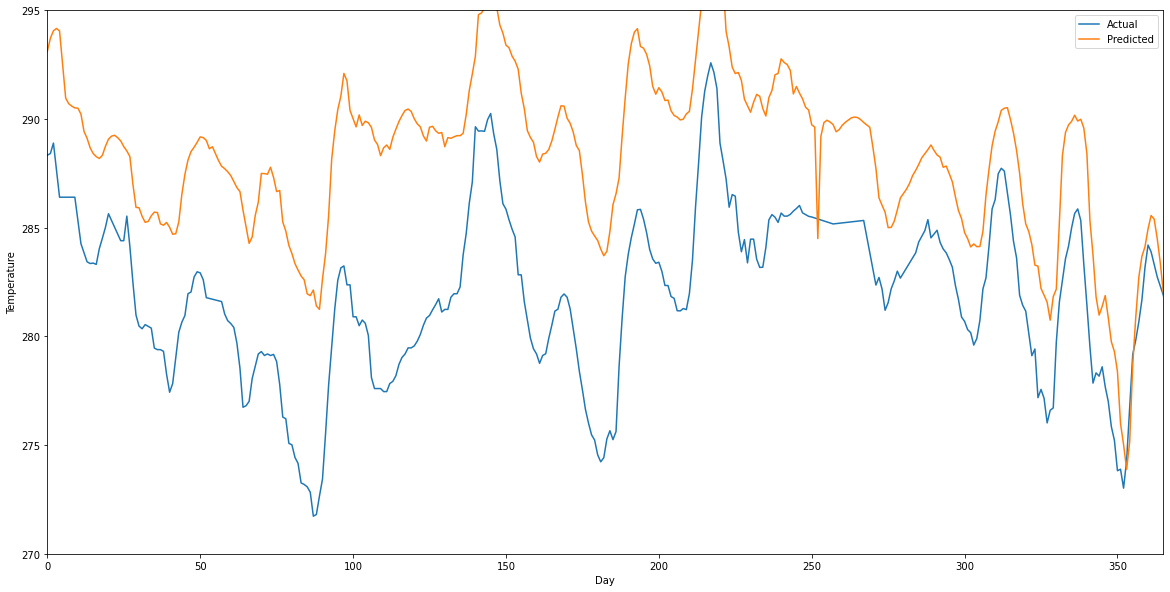

In [167]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([270, 295])
plt.legend()
plt.show()

In [168]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 10.246201515098079
R-Squared: 0.9319623803194683
RMSE: 3.2009688400698435


-----

Moving with the basic LSTM - that was the most performant model (probably because most recent temperatures are the most important indicators of future temperatures).

In [173]:
import autokeras as ak

AutoKeras does not support time series forecasting as of now

In [195]:
data = load_and_preprocess()
data = data.dropna()

In [196]:
df = data[['datetime', 'Temperature']]
df.head()

,datetime,Temperature
1,2012-10-01 13:00:00,285.830000
2,2012-10-01 14:00:00,285.834650
3,2012-10-01 15:00:00,285.847790
4,2012-10-01 16:00:00,285.860929
5,2012-10-01 17:00:00,285.874069


In [220]:
train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [222]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [227]:
X_train, y_train = split(train_std, n_timestamp=24)
X_test, y_test = split(test_std, n_timestamp=24)

In [228]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [229]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
845/845 [==============================] - 13s 12ms/step - loss: 0.0522 - val_loss: 0.0126
Epoch 2/20
845/845 [==============================] - 11s 13ms/step - loss: 0.0133 - val_loss: 0.0063
Epoch 3/20
845/845 [==============================] - 12s 14ms/step - loss: 0.0106 - val_loss: 0.0057
Epoch 4/20
845/845 [==============================] - 11s 13ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 5/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0104 - val_loss: 0.0054
Epoch 6/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0104 - val_loss: 0.0054
Epoch 7/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0103 - val_loss: 0.0055
Epoch 8/20
845/845 [==============================] - 10s 11ms/step - loss: 0.0103 - val_loss: 0.0060
Epoch 9/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0102 - val_loss: 0.0067


In [238]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

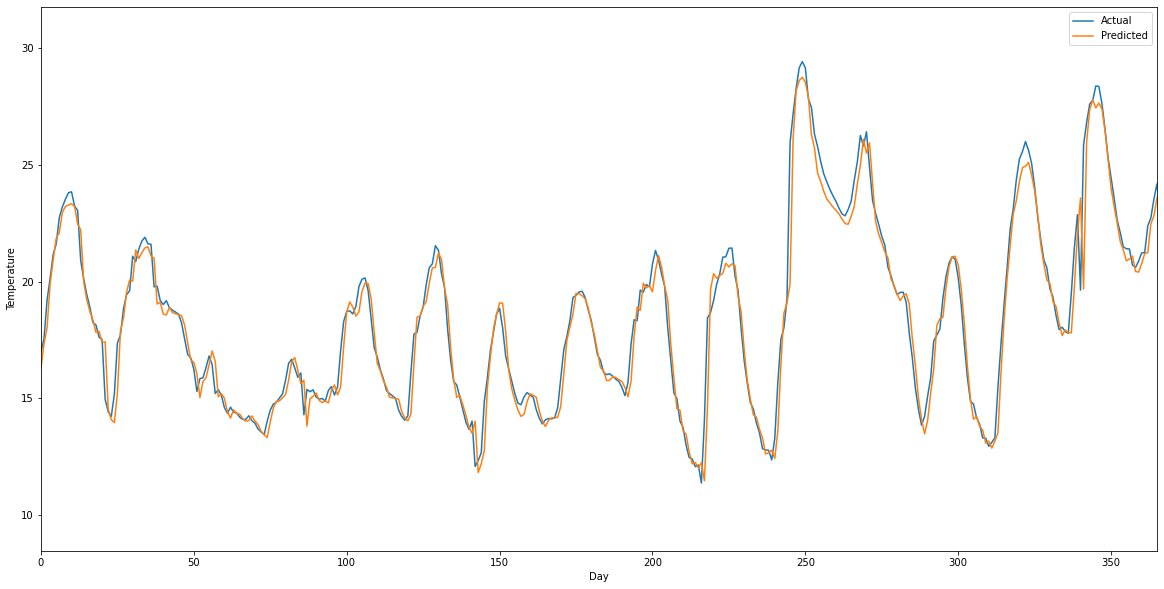

In [259]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv-273.15, label = 'Actual')
plt.plot(y_pred_inv-273.15, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([min(y_pred_inv[:366]-273.15)-3, max(y_pred_inv[:366]-273.15)+3])
plt.legend()
plt.show()

In [260]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 0.9473257996053726
R-Squared: 0.9920234593175393
RMSE: 0.9733066318511204


In [263]:
def build_lstm(X_train, n_layers = 2, cell_range = [32, 128], dropout = 0, batchnorm = False):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
    
    for i in range(n_layers-1):
        model.add(keras.layers.LSTM(random.randint(cell_range[0], cell_range[1]), return_sequences=True))
        model.add(keras.layers.Dropout(dropout))
        if batchnorm:
            model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(random.randint(cell_range[0], cell_range[1])))
    model.add(keras.layers.Dropout(dropout))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model, {'n_layers': n_layers, 'cell_min': cell_range[0], 'cell_max': cell_range[1], 'dropout': dropout, 'batchnorm': batchnorm}

In [266]:
def model_performance(model):
    history = model.fit(X_train, y_train, epochs = 100, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False, verbose = 0)
    y_pred = model.predict(X_test)
    y_pred_inv = sc.inverse_transform(y_pred)
    y_test_inv = sc.inverse_transform(y_test)
    
    return mean_squared_error(y_test_inv, y_pred_inv), r2_score(y_test_inv, y_pred_inv), math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)), np.mean(np.abs(y_test_inv, y_pred_inv), axis=1)

In [267]:
attributes = dict()
for i in range(10):
    model, atts = build_lstm(X_train, n_layers = random.randint(2, 8), cell_range = [32, 128], dropout = random.uniform(0, 0.4), batchnorm = random.choice([True, False]))
    mse, r2, rmse, mae = model_performance(model)
    atts['MSE'] = mse
    atts['R2'] = r2
    atts['RMSE'] = rmse
    atts['MAE'] = mae
    
    attributes[i] = atts

In [273]:
atts = pd.DataFrame.from_dict(attributes).T
atts.to_csv('/Users/jakehogan/Datasets/INSY695/attributes.csv', index=False)

In [281]:
atts

,n_layers,cell_min,cell_max,dropout,batchnorm,MSE,R2,RMSE,MAE
0,6,32,128,0.314141,False,1.524337,0.987165,1.23464,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
1,7,32,128,0.354219,False,2.238016,0.981156,1.496,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
2,2,32,128,0.054224,False,0.88498,0.992548,0.940734,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
3,6,32,128,0.382147,False,151.587769,-0.276378,12.312098,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
4,2,32,128,0.351246,True,46.613494,0.607512,6.827408,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
5,4,32,128,0.034029,False,0.921076,0.992244,0.959727,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
6,7,32,128,0.125432,False,1.440413,0.987872,1.200172,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
7,8,32,128,0.333512,True,108.804134,0.083863,10.430922,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
8,4,32,128,0.151818,True,52.99673,0.553764,7.279885,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."
9,2,32,128,0.308896,False,1.113321,0.990626,1.05514,"[290.14, 290.71, 292.36, 293.3, 294.32, 294.77..."


In [296]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 64, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64, return_sequences=True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [297]:
history = model.fit(X_train, y_train, epochs = 100, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.1, shuffle=False)

Epoch 1/100
950/950 [==============================] - 19s 17ms/step - loss: 0.0909 - val_loss: 0.0243
Epoch 2/100
950/950 [==============================] - 16s 17ms/step - loss: 0.0200 - val_loss: 0.0091
Epoch 3/100
950/950 [==============================] - 18s 18ms/step - loss: 0.0148 - val_loss: 0.0066
Epoch 4/100
950/950 [==============================] - 20s 21ms/step - loss: 0.0135 - val_loss: 0.0090
Epoch 5/100
950/950 [==============================] - 20s 21ms/step - loss: 0.0128 - val_loss: 0.0113
Epoch 6/100
950/950 [==============================] - 17s 18ms/step - loss: 0.0130 - val_loss: 0.0122


In [298]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

In [299]:
y_pred.shape

(11438, 1)

In [300]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 1.5056531711712944
R-Squared: 0.9873223089896562
RMSE: 1.2270505984560272


In [304]:
preds = pd.DataFrame(data=df.loc[cutoff+24+1:, 'datetime'])
preds['actual'] = df.loc[cutoff+24+1:, 'Temperature']
preds['pred'] = y_pred_inv
preds['MAE'] = np.mean(np.abs(y_test_inv - y_pred_inv), axis=1)
preds['datetime'] = pd.to_datetime(preds['datetime'])

preds_day = preds.groupby(preds['datetime'].dt.date).agg('mean') #grouping by day

In [305]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['actual']-273.15, name='Actual'))
fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['pred']-273.15, name='Predicted'))
fig.update_layout(showlegend=True, title='Test Predictions/Actual Temperatures')
fig.show()

In [311]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,Temperature
1,2012-10-01 13:00:00,285.830000
2,2012-10-01 14:00:00,285.834650
3,2012-10-01 15:00:00,285.847790
4,2012-10-01 16:00:00,285.860929
5,2012-10-01 17:00:00,285.874069


In [317]:
df2 = df.groupby(df.datetime.dt.date).agg('mean')
df2['datetime'] = pd.to_datetime(df2.index)
df2 = df2.reset_index(drop=True)
df2.head()

,Temperature,datetime
0,285.887980,2012-10-01
1,286.937931,2012-10-02
2,287.374583,2012-10-03
3,286.860833,2012-10-04
4,287.535208,2012-10-05


In [318]:
cutoff = int(len(df2)*0.75)
train = df2[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df2[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [319]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

X_train, y_train = split(train_std, 24)
X_test, y_test = split(test_std, 24)

In [320]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 64, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64, return_sequences=True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [321]:
history = model.fit(X_train, y_train, epochs = 100, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.1, shuffle=False)

Epoch 1/100
40/40 [==============================] - 5s 40ms/step - loss: 0.4940 - val_loss: 0.2423
Epoch 2/100
40/40 [==============================] - 1s 18ms/step - loss: 0.2588 - val_loss: 0.1806
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 0.2166 - val_loss: 0.1816
Epoch 4/100
40/40 [==============================] - 1s 17ms/step - loss: 0.2209 - val_loss: 0.1655
Epoch 5/100
40/40 [==============================] - 1s 21ms/step - loss: 0.2161 - val_loss: 0.1665
Epoch 6/100
40/40 [==============================] - 1s 19ms/step - loss: 0.2107 - val_loss: 0.1606
Epoch 7/100
40/40 [==============================] - 1s 18ms/step - loss: 0.2065 - val_loss: 0.1568
Epoch 8/100
40/40 [==============================] - 1s 18ms/step - loss: 0.2030 - val_loss: 0.1521
Epoch 9/100
40/40 [==============================] - 1s 17ms/step - loss: 0.1956 - val_loss: 0.1479
Epoch 10/100
40/40 [==============================] - 1s 18ms/step - loss: 0.1901 - val_loss: 0.1432

In [322]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

In [323]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 11.669811772758257
R-Squared: 0.8916852026617252
RMSE: 3.416110620685205


In [326]:
preds = pd.DataFrame(data=df2.loc[cutoff+24:, 'datetime'])
preds['actual'] = df2.loc[cutoff+24:, 'Temperature']
preds['pred'] = y_pred_inv
preds['MAE'] = np.mean(np.abs(y_test_inv - y_pred_inv), axis=1)
preds['datetime'] = pd.to_datetime(preds['datetime'])

preds_day = preds.groupby(preds['datetime'].dt.date).agg('mean') #grouping by day

In [327]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['actual']-273.15, name='Actual'))
fig.add_trace(go.Scatter(x=preds_day.index, y=preds_day['pred']-273.15, name='Predicted'))
fig.update_layout(showlegend=True, title='Test Predictions/Actual Temperatures')
fig.show()